Following notes from this page: https://medium.com/modern-physics/finite-difference-solution-of-the-schrodinger-equation-c49039d161a8

In [1]:
# import libraries
import numpy as np
import sys
import psi4
from helper_PFCI import PFHamiltonianGenerator
np.set_printoptions(threshold=sys.maxsize)
import scipy
from scipy.optimize import curve_fit
from scipy import interpolate
from matplotlib import pyplot as plt
from scipy import constants
from numpy.polynomial import Polynomial

In [2]:
# z-matrix for LiH
mol_str_LiH = """
Li
H 1 1.546938775510204
symmetry c1
"""

# options for the PFHamiltonian Generator class - include cavity effects
cavity_dict = {
    'omega_value' : 0.12086,
    'lambda_vector' : np.array([0, 0, 0.1]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 1, #<== this is a minimal photon basis, should explore increasing this 
}

# options for PFHamiltonian Generator class - exclude cavity effects
cavity_free_dict = {
    'omega_value' : 0.0,
    'lambda_vector' : np.array([0, 0, 0.0]),
    'ci_level' : 'fci',   
    'full_diagonalization' : True,
    'number_of_photons' : 0, 
}

In [5]:
mol_tmpl = """
Li
H 1 **R**
symmetry c1
"""
options_dict = {
    "basis": "sto-3g",
    "scf_type": "pk",
    "e_convergence": 1e-10,
    "d_convergence": 1e-10,
    'num_roots' : 2
}

# number of bondlengths in the scan
N_R = 50

# number of electronic states to save
N_el = 10

# array  for energies inside the cavity
cavity_E_array_LiH = np.zeros((N_R, N_el))

r_data = np.linspace(1.2, 2.0, 50)
psi4.set_options(options_dict)
fci_S0 = []
fci_S1 = []
r_idx_LiH = 0
for r in r_data:
    mol_str = mol_tmpl.replace("**R**", str(r))
    mol = psi4.geometry(mol_str)
    scf_e, wfn = psi4.energy('SCF', return_wfn=True)
    fci_energy, wfn = psi4.energy('fci',ref_wfn=wfn, return_wfn=True)
    fci_S0.append(wfn.variable("CI ROOT 0 TOTAL ENERGY"))
    fci_S1.append(wfn.variable("CI ROOT 1 TOTAL ENERGY"))
    LiH_cav = PFHamiltonianGenerator(mol_str, options_dict, cavity_dict)
    cavity_E_array_LiH[r_idx_LiH,:] = LiH_cav.CIeigs[:N_el]
    r_idx_LiH += 1


Scratch directory: /tmp/
   => Libint2 <=

    Primary   basis highest AM E, G, H:  5, 4, 3
    Auxiliary basis highest AM E, G, H:  6, 5, 4
    Onebody   basis highest AM E, G, H:  6, 5, 4
    Solid Harmonics ordering:            gaussian

*** tstart() called on CHEM92KWMALT
*** at Mon Jan 22 13:09:53 2024

   => Loading Basis Set <=

    Name: STO-3G
    Role: ORBITAL
    Keyword: BASIS
    atoms 1 entry LI         line    31 file /Users/ptolley1/anaconda3/envs/work/share/psi4/basis/sto-3g.gbs 
    atoms 2 entry H          line    19 file /Users/ptolley1/anaconda3/envs/work/share/psi4/basis/sto-3g.gbs 


         ---------------------------------------------------------
                                   SCF
               by Justin Turney, Rob Parrish, Andy Simmonett
                          and Daniel G. A. Smith
                              RHF Reference
                        1 Threads,    500 MiB Core
         ---------------------------------------------------------

  ==> 

Min on S0 is 1.5428571428571427
Min on S0 is 1.853061224489796
148.390843073308
44.790945881691336


<function matplotlib.pyplot.show(close=None, block=None)>

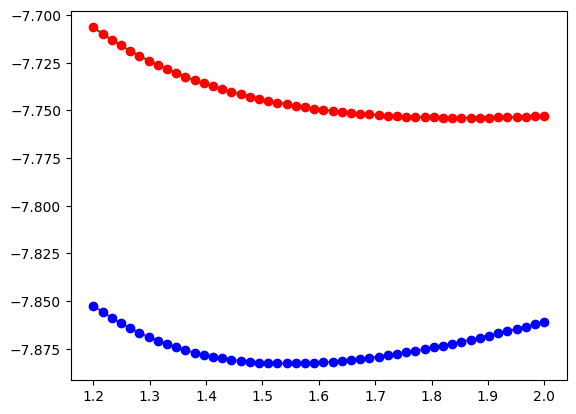

In [6]:
au_to_SI = (4.35974 * 10 ** (-18)) * 10 ** 20
min_S0_loc = np.argmin(fci_S0[:])
min_S1_loc = np.argmin(fci_S1[:])
r_eq_ang = r_data[min_S0_loc]
r_eq_S1_ang = r_data[min_S1_loc]
print(f'Min on S0 is {r_data[min_S0_loc]}')
print(f'Min on S0 is {r_data[min_S1_loc]}')
mu_amu = 1.00784 * 6.9410 / (1.00784 + 6.9410)
mu_kg = mu_amu  * 10 ** (-3) / (6.022 * 10 ** 23) 
r_eq_SI = r_eq_ang * 10 ** (-10)
r_eq_S1_SI = r_eq_S1_ang * 10 ** (-10)

# Fitting S0 PES to a quintic polynomial
poly = np.poly1d(np.polyfit(r_data, fci_S0, 5))
poly_e = np.poly1d(np.polyfit(r_data, fci_S1, 5))

#Taking first and second derivative of S0 PES and evaluating at r_eq
first_derivative = poly.deriv()
second_derivative = first_derivative.deriv()
k_test_au = second_derivative(r_eq_ang)
k_test_SI = k_test_au * au_to_SI
print(k_test_SI)

first_derivative_S1 = poly_e.deriv()
second_derivative_S1 = first_derivative_S1.deriv()
k_test_S1_au = second_derivative_S1(r_eq_S1_ang)
k_test_S1_SI = k_test_S1_au * au_to_SI
print(k_test_S1_SI)


#plotting S0 PES and quintic fit
plt.plot(r_data, poly(r_data), 'm-', label='fit')
plt.plot(r_data, fci_S0[:], 'bo', label='cavity free |g>')
plt.plot(r_data, poly_e(r_data), 'g-', label='fit')
plt.plot(r_data, fci_S1[:], 'ro', label='cavity free |e>')
plt.show

## Ground Electronic State

In [8]:

# define smallest and largest bondlengths in atomic units (here x=0 is the equilibrium value)
x_min = 1.2 * 10 ** (-10)
x_max = 2.0 * 10 ** (-10)

hbar = scipy.constants.hbar
r_eq_SI = r_eq_ang * 10 ** (-10)

# number of grid points 
N = 1001

# define grid
x = np.linspace(x_min, x_max, N)

# define grid spacing h
h = x[1]-x[0]

# compute Harmonic potential with k = 1
def Vpot(x):
    return  1/2 * k_test_SI * (x - r_eq_SI) ** 2

V_x = Vpot(x)

# create arrays for T, V, and H - we truncate the smallest and largest grid points where 
# the centered finite difference derivatives cannot be defined
T = np.zeros((N-2, N-2))
V = np.zeros((N-2, N-2))
H = np.zeros((N-2, N-2))

# this uses the 3 point stencil; we can adapt to use a 5 point and it might improve accuracy
for i in range(N-2):
    for j in range(N-2):
        if i==j:
            T[i,j]= -2
        elif np.abs(i-j)==1:
            T[i,j]=1
        else:
            T[i,j]=0



for i in range(N-2):
    for j in range(N-2):
        if i==j:
            V[i,j]= Vpot(x[i+1])
        else:
            V[i,j]=0
            
H = -T * hbar ** 2/(2*mu_kg*h**2) + V

vals, vecs = np.linalg.eigh(H)
print(vals[0])
print(vecs[0,:])

1.7020486109940026e-20
[-8.75757141e-05 -2.18808449e-04  3.62117182e-04  5.03582291e-04
 -6.48860274e-04 -7.96304132e-04  9.43136259e-04  1.08872047e-03
 -1.23321926e-03 -1.37689163e-03  1.51994521e-03  1.66252910e-03
 -1.80474872e-03 -1.94667926e-03  2.08837531e-03  2.22987713e-03
 -2.37121493e-03 -2.51241171e-03  2.65348517e-03  2.79444909e-03
 -2.93531428e-03 -3.07608926e-03  3.21678082e-03  3.35739431e-03
 -3.49793402e-03 -3.63840332e-03  3.77880487e-03  3.91914075e-03
 -4.05941254e-03 -4.19962144e-03  4.33976828e-03  4.47985365e-03
 -4.61987786e-03 -4.75984103e-03  4.89974313e-03  5.03958396e-03
 -5.17936318e-03 -5.31908036e-03 -5.45873496e-03  5.59832637e-03
  5.73785388e-03 -5.87731675e-03 -6.01671415e-03  6.15604523e-03
  6.29530906e-03 -6.43450469e-03 -6.57363115e-03  6.71268740e-03
  6.85167241e-03 -6.99058510e-03 -7.12942437e-03  7.26818911e-03
  7.40687819e-03 -7.54549045e-03 -7.68402473e-03  7.82247985e-03
  7.96085460e-03 -8.09914780e-03 -8.23735823e-03  8.37548466e-03
  

## Excited Electronic State

In [9]:

r_eq_S1_SI = r_eq_S1_ang * 10 ** (-10)


# compute Harmonic potential with k = 1
def Vpot_e(x):
    return  1/2 * k_test_S1_SI * (x - r_eq_S1_SI) ** 2

V_x_e = Vpot_e(x)

# create arrays for T, V, and H - we truncate the smallest and largest grid points where 
# the centered finite difference derivatives cannot be defined
T_e = np.zeros((N-2, N-2))
V_e = np.zeros((N-2, N-2))
H_e = np.zeros((N-2, N-2))

# this uses the 3 point stencil; we can adapt to use a 5 point and it might improve accuracy
for i in range(N-2):
    for j in range(N-2):
        if i==j:
            T_e[i,j]= -2
        elif np.abs(i-j)==1:
            T_e[i,j]=1
        else:
            T_e[i,j]=0



for i in range(N-2):
    for j in range(N-2):
        if i==j:
            V_e[i,j]= Vpot_e(x[i+1])
        else:
            V_e[i,j]=0
            
H_e = -T_e * hbar ** 2/(2*mu_kg*h**2) + V_e

vals_e, vecs_e = np.linalg.eigh(H_e)
print(vals_e[0])
print(vecs_e[0,:])

1.621623962845469e-20
[ 1.43091382e-05 -8.50766476e-05 -2.41033329e-04  4.28023985e-04
  6.02630813e-04 -7.64077865e-04 -9.18124038e-04  1.06804174e-03
  1.21547027e-03 -1.36128317e-03 -1.50598361e-03  1.64988135e-03
  1.79317760e-03 -1.93600882e-03 -2.07847086e-03  2.22063298e-03
  2.36254640e-03 -2.50424982e-03 -2.64577288e-03  2.78713868e-03
  2.92836537e-03 -3.06946738e-03 -3.21045626e-03  3.35134130e-03
  3.49213004e-03 -3.63282858e-03 -3.77344187e-03  3.91397395e-03
  4.05442807e-03 -4.19480685e-03 -4.33511238e-03  4.47534632e-03
  4.61550994e-03 -4.75560420e-03 -4.89562977e-03  5.03558712e-03
  5.17547648e-03 -5.31529794e-03 -5.45505141e-03  5.59473670e-03
  5.73435349e-03 -5.87390134e-03 -6.01337975e-03  6.15278813e-03
  6.29212581e-03 -6.43139207e-03 -6.57058613e-03  6.70970717e-03
  6.84875432e-03 -6.98772666e-03 -7.12662324e-03  7.26544308e-03
  7.40418519e-03 -7.54284851e-03 -7.68143200e-03  7.81993458e-03
  7.95835513e-03 -8.09669256e-03 -8.23494572e-03  8.37311347e-03
  8

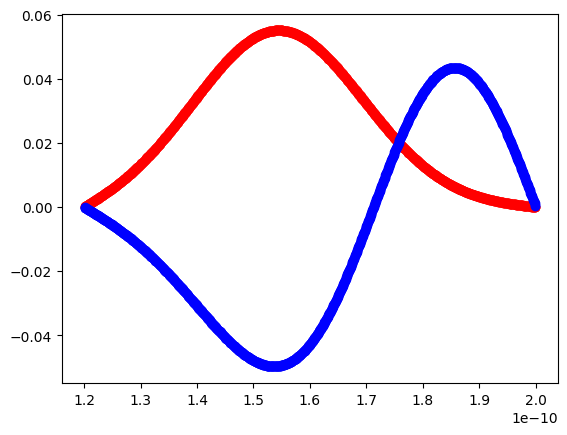

In [18]:
#plt.plot(x, V_x)
plt.plot(x[1:1000], -vecs[:,0], 'ro')
plt.plot(x[1:1000], vecs_e[:,1], 'bo')

## Franck-Condon Factor Calculation

In [19]:
psi_g = -vecs[:,0]
psi_e = vecs[:1]
FCF = np.trapz(psi_g * psi_e) 
print(FCF)

[-1.81304125e-05]
